In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from random import randrange
import cv2 as cv
# import glob
import pickle

from tensorflow import keras
from keras.layers import *
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [2]:
DATA_FOLDER='/home/fra/Scrivania/Deepfake-Detection/dataset/kaggle'

DATA_RAW= 'raw_data'
TEST_FOLDER='test_video'
#input folder kaggle
ORIGINAL_FOLDER='original'
MANIPULATED_FOLDER='fake'

#output folder preprocess google
IMG_ORIGINAL_FOLDER  ='/home/fra/Scrivania/Deepfake-Detection/dataset/kaggle/preprocess-output/real_png'
IMG_MANIPULATED_FOLDER='/home/fra/Scrivania/Deepfake-Detection/dataset/kaggle/preprocess-output/fake_png'
IMG_TEST_FOLDER='/home/fra/Scrivania/Deepfake-Detection/dataset/kaggle/preprocess-output/test_png'

root_folder_test=os.path.join(DATA_FOLDER, TEST_FOLDER)


In [3]:
IMAGE_RESIZE = 180
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']


In [11]:
from keras.preprocessing.image import img_to_array, load_img

FRAME_X_VIDEO=5

MAX_VIDEO_REAL=150
MAX_VIDEO_FAKE=150


X_train = []
Y_train = []

train_original    = os.listdir(IMG_ORIGINAL_FOLDER)
train_manipulated = os.listdir(IMG_MANIPULATED_FOLDER)



count_fake=0        
count_real=0

    
while count_real<MAX_VIDEO_REAL:

    next_video_index = randrange(0,len(train_original))
    #randomly we choose a video_dir from the train folder
    video_dir=train_original[next_video_index]
    #randomly from that video_folder we choose some frame for the training
    frames_taken=0
    candidate_frame= list(os.listdir(os.path.join(IMG_ORIGINAL_FOLDER, video_dir)))

    if len(candidate_frame)>20:
        count_real+=1        

        while frames_taken<FRAME_X_VIDEO:
            random_index=randrange(0,len(candidate_frame))  
            X_train.append(img_to_array(
                load_img(
                os.path.join(IMG_ORIGINAL_FOLDER, video_dir,candidate_frame[random_index]),
                target_size=(128, 128) )
                    )            )
            Y_train.append(0)

            frames_taken+=1
            #remove the selected frame
            del candidate_frame[random_index]
        #remove the selected video from the frontier
        del train_original[next_video_index]


while count_fake<MAX_VIDEO_FAKE: 

    next_video_index = randrange(0,len(train_manipulated))
    #randomly we choose a video_dir from the train folder
    video_dir=train_manipulated[next_video_index]
    #randomly from that video_folder we choose some frame for the training
    frames_taken=0
    candidate_frame= list(os.listdir(os.path.join(IMG_MANIPULATED_FOLDER, video_dir)))

    if len(candidate_frame)>20:
        count_fake+=1        

        while frames_taken<FRAME_X_VIDEO:
            random_index=randrange(0,len(candidate_frame))  
            X_train.append(img_to_array(
                load_img(
                os.path.join(IMG_MANIPULATED_FOLDER, video_dir,candidate_frame[random_index]),
                target_size=(128, 128) )
                    )            )
            Y_train.append(1)

            frames_taken+=1
            #remove the selected frame
            del candidate_frame[random_index]
        #remove the selected video from the frontier
        del train_manipulated[next_video_index]    

        
print(len(X_train))
data= {}
data["X_train"] = X_train
data["Y_train"] = Y_train


output = open('train_300_kaggle.pkl', 'wb')
pickle.dump(data, output)
output.close()
print("DATA Saved")   

1500
DATA Saved


In [6]:
test_list=os.listdir(root_folder_test)


json_test_file=[file for file in test_list if  file.endswith('json')][0]
print(f"JSON TEST file: {json_test_file}")

def get_meta_from_json(path):
    df = pd.read_json(os.path.join(DATA_FOLDER, path, json_test_file))
    df = df.T
    return df
meta_test_df = get_meta_from_json(TEST_FOLDER)
meta_test_df.head()

JSON TEST file: metadata.json


,label,split,original
qzhrdqxpax.mp4,FAKE,train,rlhmppiklf.mp4
mthkmtbuab.mp4,REAL,train,NaN
jgmtynuyqc.mp4,FAKE,train,xkrhzvriqg.mp4
fbosopvlqz.mp4,FAKE,train,ivssyazqtr.mp4
trzdsncewk.mp4,FAKE,train,fsxwyhjxgo.mp4


In [13]:
VIDEO_TEST= 100

test_videos= os.listdir(IMG_TEST_FOLDER)

X_val=[]
Y_val=[]

count_test=0

while count_test<VIDEO_TEST:
    next_video_index = randrange(0,len(test_videos))
    #randomly we choose a video_dir from the train folder
    video_dir=test_videos[next_video_index]
    #randomly from that video_folder we choose some frame for the training
    frames_taken=0
    candidate_frame= list(os.listdir(os.path.join(IMG_TEST_FOLDER, video_dir)))
    if len(candidate_frame)>20:
        count_test+=1        
        while frames_taken<FRAME_X_VIDEO:
            random_index=randrange(0,len(candidate_frame))  
            X_val.append(img_to_array(
                load_img(
                os.path.join(IMG_TEST_FOLDER, video_dir,candidate_frame[random_index]),
                target_size=(128, 128) )
                    )            )
            
            if meta_test_df.loc[video_dir].label=='REAL':
                Y_val.append(0)
            else:
                Y_val.append(1)

            
            frames_taken+=1
            #remove the selected frame
            del candidate_frame[random_index]
        #remove the selected video from the frontier
        del test_videos[next_video_index]


        
print(len(X_val))

data_val= {}

data_val["X_val"] = X_val
data_val["Y_val"] = Y_val


output = open('validation_100_kaggle.pkl', 'wb')
pickle.dump(data_val, output)
output.close()
print("DATA Saved")   

500
DATA Saved


In [ ]:
#Using the model

In [4]:
# load data file
pkl_file1 = open('train_300_kaggle.pkl', 'rb')
train = pickle.load(pkl_file1)
pkl_file1.close()
X_train = train["X_train"]
Y_train = train["Y_train"]

pkl_file2 = open('validation_100_kaggle.pkl', 'rb')
val = pickle.load(pkl_file2)
pkl_file2.close()
X_val = val["X_val"]
Y_val = val["Y_val"]



In [5]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Normalization

X_train= np.array(X_train)
Y_train= to_categorical(Y_train, 2)

X_val=np.array(X_val)
Y_val= to_categorical(Y_val, 2)

# #Reshape
X_train = X_train.reshape(-1, 128, 128, 3)
X_val = X_val.reshape(-1, 128, 128, 3)


# #Train-Test split
# X_train1, X_val1, Y_train1, Y_val1 = train_test_split(X_train, Y_train, test_size = 0.2, random_state=5)

In [6]:
print(X_train.shape,Y_train.shape,X_val.shape)

(1500, 128, 128, 3) (1500, 2) (500, 128, 128, 3)


In [10]:
#define a new activation

from keras.backend import sigmoid

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})


In [12]:
from keras.applications.resnet50 import ResNet50

resnet = ResNet50(include_top = False, pooling = 'avg', weights='imagenet')
resnet.trainable=True

model = Sequential()
model.add(resnet)
model.add(Dense(256, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 24,112,770
Trainable params: 24,059,650
Non-trainable params: 53,120
_________________________________________________________________


In [19]:
#optimizer
ada_delta = optimizers.Adadelta(lr=0.001, rho=0.95, epsilon=1e-07 )

adam=optimizers.Adam(lr=1e-5, decay=1e-6)

epochs=10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)



model.compile(optimizer = adam,
              loss = 'categorical_crossentropy', metrics = LOSS_METRICS)


early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0)

In [20]:
history1=model.fit(X_train, Y_train, 
                    batch_size = 100, 
                    epochs = 10, 
                    validation_data = (X_val, Y_val), 
                    verbose = 1
#          callbacks=[early_stopping]
         )

Train on 2000 samples, validate on 500 samples
Epoch 1/10
2000/2000 [==============================] - 668s 334ms/step - loss: 0.4575 - accuracy: 0.7780 - val_loss: 0.7112 - val_accuracy: 0.6700
Epoch 2/10
2000/2000 [==============================] - 560s 280ms/step - loss: 0.4183 - accuracy: 0.8045 - val_loss: 0.6927 - val_accuracy: 0.6780
Epoch 3/10
2000/2000 [==============================] - 622s 311ms/step - loss: 0.4038 - accuracy: 0.8065 - val_loss: 0.6875 - val_accuracy: 0.6800
Epoch 4/10
2000/2000 [==============================] - 621s 311ms/step - loss: 0.3868 - accuracy: 0.8130 - val_loss: 0.6906 - val_accuracy: 0.6820
Epoch 5/10
2000/2000 [==============================] - 623s 312ms/step - loss: 0.3687 - accuracy: 0.8225 - val_loss: 0.6629 - val_accuracy: 0.6920
Epoch 6/10
2000/2000 [==============================] - 612s 306ms/step - loss: 0.3616 - accuracy: 0.8290 - val_loss: 0.6644 - val_accuracy: 0.6900
Epoch 7/10
2000/2000 [==============================] - 608s 304m

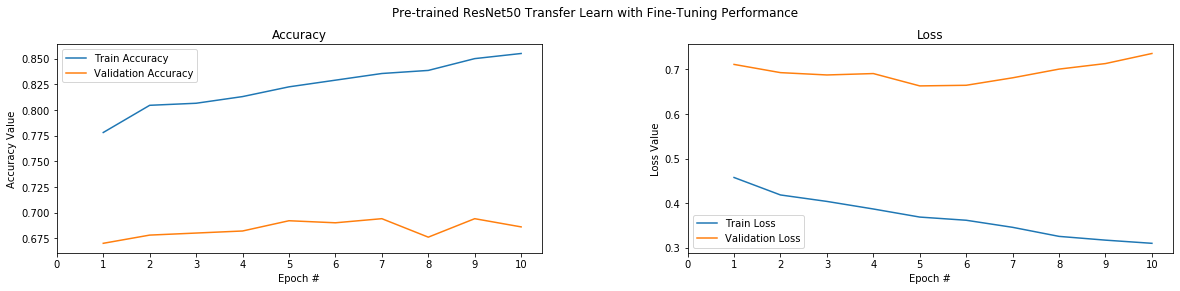

In [21]:
EPOCHS=10



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained ResNet50 Transfer Learn with Fine-Tuning Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history1.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history1.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [18]:
model.save("resnet50_sgd(500)_model.h5")

In [25]:
from keras.applications import ResNet152V2

resnet152V2=ResNet152V2(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
    pooling='avg')

model152V2 = Sequential()
model152V2.add(resnet152V2)
model152V2.add(Dense(256, activation='relu'))
model152V2.add(Dropout(.5))
model152V2.add(Dense(units=2, activation='softmax'))
model152V2.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 2048)              58331648  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 58,856,706
Trainable params: 58,712,962
Non-trainable params: 143,744
_________________________________________________________________


In [26]:
ada_delta = optimizers.Adadelta(lr=1e-7, rho=0.95, epsilon=1e-07 )

adam=optimizers.Adam(lr=1e-5, decay=1e-6)

epochs=10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model152V2.compile(optimizer = sgd,
              loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0)

In [27]:
history2=model152V2.fit(X_train, Y_train, 
                    batch_size = 40, 
                    epochs = 10, 
                    validation_data = (X_val, Y_val), 
                    verbose = 1)

Train on 750 samples, validate on 375 samples
Epoch 1/10
750/750 [==============================] - 561s 748ms/step - loss: 3.0398 - accuracy: 0.6373 - val_loss: nan - val_accuracy: 0.2133
Epoch 2/10
750/750 [==============================] - 459s 613ms/step - loss: 0.9168 - accuracy: 0.6667 - val_loss: 18134993508568049834983948288.0000 - val_accuracy: 0.2133
Epoch 3/10
750/750 [==============================] - 478s 637ms/step - loss: 0.7520 - accuracy: 0.6533 - val_loss: 6117008716361018.0000 - val_accuracy: 0.2133
Epoch 4/10
750/750 [==============================] - 511s 681ms/step - loss: 0.6454 - accuracy: 0.6653 - val_loss: 37650909511.6800 - val_accuracy: 0.2133
Epoch 5/10
750/750 [==============================] - 458s 611ms/step - loss: 0.6390 - accuracy: 0.6627 - val_loss: 44507874.8800 - val_accuracy: 0.2133
Epoch 6/10
750/750 [==============================] - 452s 603ms/step - loss: 0.6384 - accuracy: 0.6640 - val_loss: 771256.0750 - val_accuracy: 0.2133
Epoch 7/10
750/7

In [28]:
model152V2.save("resnet152V2_sgd(150)_model.h5")

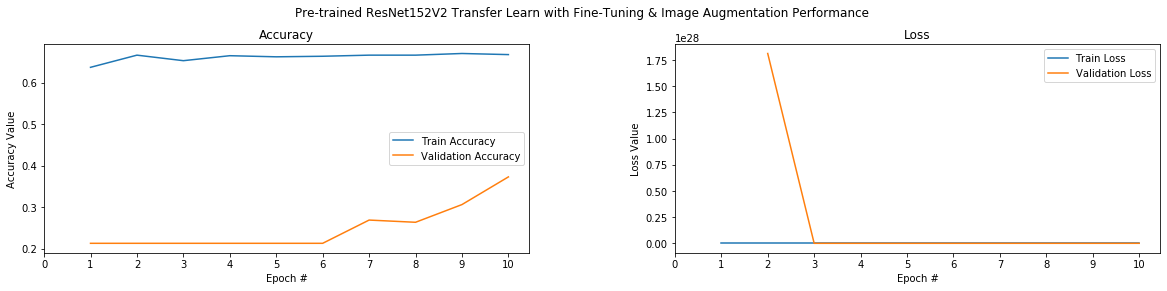

In [29]:
EPOCHS=10



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained ResNet152V2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [7]:
from keras.applications import InceptionResNetV2

inceptionResNet=InceptionResNetV2(
    include_top=False, weights='imagenet', pooling='avg')

model3 = Sequential()
model3.add(inceptionResNet)
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(.5))
model3.add(Dense(units=2, activation='softmax'))
model3.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 54,730,722
Trainable params: 54,670,178
Non-trainable params: 60,544
_________________________________________________________________


In [12]:
ada_delta = optimizers.Adadelta(lr=1e-7, rho=0.95, epsilon=1e-07 )

adam=optimizers.Adam(lr=1e-5, decay=1e-6)

epochs=10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)


model3.compile(optimizer = adam,
              loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [13]:
history3=model3.fit(X_train, Y_train, 
                    batch_size = 100, 
                    epochs = 10, 
                    validation_data = (X_val, Y_val), 
                    verbose = 1)

Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 435s 290ms/step - loss: 0.2722 - accuracy: 0.8753 - val_loss: 1.9512 - val_accuracy: 0.2800
Epoch 2/10
1500/1500 [==============================] - 264s 176ms/step - loss: 0.2433 - accuracy: 0.8813 - val_loss: 2.1193 - val_accuracy: 0.2600
Epoch 3/10
1500/1500 [==============================] - 247s 165ms/step - loss: 0.2171 - accuracy: 0.8960 - val_loss: 2.2771 - val_accuracy: 0.2420
Epoch 4/10
1500/1500 [==============================] - 247s 165ms/step - loss: 0.2055 - accuracy: 0.8993 - val_loss: 2.2905 - val_accuracy: 0.2460
Epoch 5/10
1500/1500 [==============================] - 246s 164ms/step - loss: 0.1918 - accuracy: 0.9007 - val_loss: 2.3535 - val_accuracy: 0.2440
Epoch 6/10
1500/1500 [==============================] - 248s 165ms/step - loss: 0.1870 - accuracy: 0.9107 - val_loss: 2.4519 - val_accuracy: 0.2400
Epoch 7/10
1500/1500 [==============================] - 251s 167m

In [10]:
model3.save("ada_InceptionResnetv2_sgd(400)_model.h5")

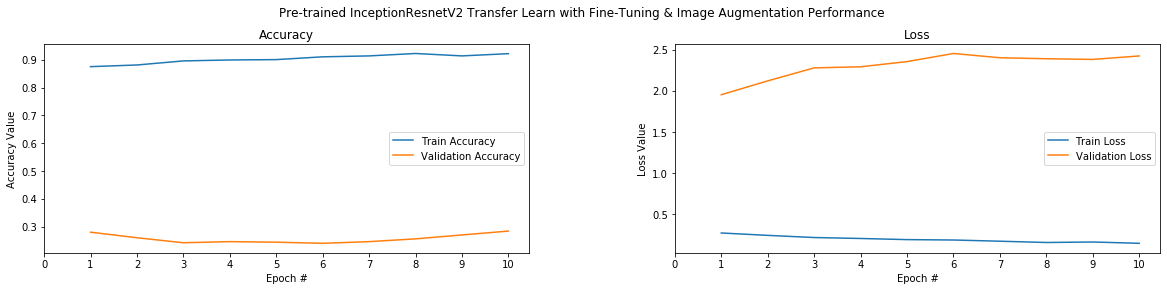

In [14]:
EPOCHS=10



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResnetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")